결정 트리(Decision Tree, 의사결정트리, 의사결정나무라고도 함)는 분류(Classification)와 회귀(Regression) 모두 가능한 지도 학습 모델 중 하나입니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

## 6.1 결정 트리 학습과 시각화

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

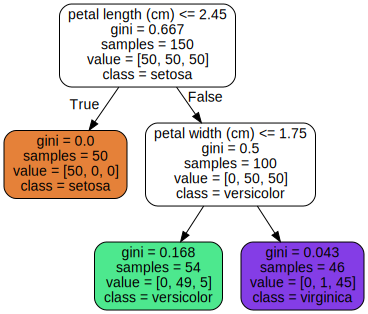

In [3]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

# 6.2 예측하기

1. 깊이가 0인 맨 꼭대기노드인 루트노드에서 시작한다.
2. True면 왼쪽 자식노드(child Node)로 이동한다.
> 이 노드 밑에 자식노드를 가지고 있지 않기 때문에 리프노드가 되고 추가 검사를 하지 않느다.
3. 다른 꽃을 발견하면 루트 노드의 오른쪽 자식노드로 이동한다.

- 불순도

얼마나 다양한 범주들의 객체들이 포함되어 있는가

- 지니 불순도

지니 불순도는 집합에 이질적인 것이 얼마나 섞였는지를 측정하는 지표이며 CART 알고리즘에서 사용한다. 어떤 집합에서 한 항목을 뽑아 무작위로 라벨을 추정할 때 틀릴 확률을 말한다. 집합에 있는 항목이 모두 같다면 지니 불순도는 최솟값(0)을 갖게 되며 이 집합은 완전히 순수하다고 할 수 있다. 데이터의 통계적 분산정도를 정량화해서 표현한값

**식 6-1: 지니 불순도**

$
G_i = 1 - \sum\limits_{k=1}^{n}{{p_{i,k}}^2}
$





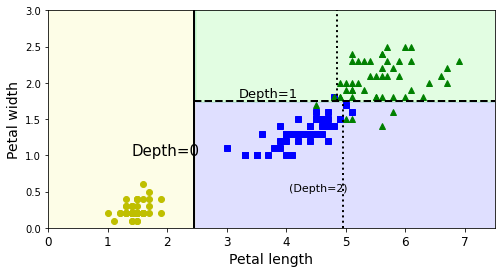

In [4]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)


plt.show()

# 6.3 클래스 확률 추정

결정 트리는 한 샘플이 특정 클래스 k에 속할 확률을 추정할 수도 있다.
- 샘플에 대해 리프 노드를 찾기 위해 트리를 탐색하고 그 노드에 있는 클래스 k의 훈련 샘플의 비율을 반환한다.
> 길이가 5cm이고 너비가 1.5cm인 꽃잎을 발견했을때 해당하는 리프 노드는 깊이가 2에서 왼쪽 노드이므로 결정 츠리는 그에 해당하는 확률을 출력한다.

In [5]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [6]:
tree_clf.predict([[5, 1.5]])

array([1])

# 6.4 CART 훈련 알고리즘

- CART

트리를 이용한 분류/숫자예측

1. 훈련 세트를 하나의 특성 $k$ 의 임계값 $t_k$를 사용해 두개의 서브넷으로 나눈다. 
2. 가장 순수한 서브셋으로 나눌수 있는 $(k,t_k)$ 짝을 찾는다.

**식 6-2: 분류에 대한 CART 비용 함수**

$
\begin{split}
&J(k, t_k) = \dfrac{m_{\text{left}}}{m}G_\text{left} + \dfrac{m_{\text{right}}}{m}G_{\text{right}}\\
&\text{여기에서 }\begin{cases}
G_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 불순도}\\
m_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 샘플 수}
\end{cases}
\end{split}
$

탐욕적 알고리즘이다. 맨 위 루트 노드에서 최적의 분할을 찾으며 이어지는 각 단계에서 이 과정을 반복한다. 현재 단계의 분할이 몇 단계를 거처 가장 낮은 불순도로 이어질 수 있을지 없을지는 고려하지 않는다.

# 6.5 계산 복잡도

예측을 하려면 결증 트리를 루트노드에서 리프노드까지 탐색해야한다.
결정 트리 탐색하기 위해서는 약 $O(log_2(m))$개의 노드를 거쳐야한다. 전체 복잡도는 특성수와 무관하게 동일하다.

훈련 알고지름은 각 도느에서 모든 훈련 샘플의 모든특성을 비교한다. 각 노드에서 모든 샘플의 모든 특성을 비교하면 $O(n*mlog_2(m))$이 된다. 훈련세트가 작을경우 사이킷런은 미리 데이터를 정렬하여 훈련속도를 높일수있다. 훈련세트가 클경우 느려진다.

#6.6 지니불순도 또는 엔트로피?

- 엔트로피

엔트로피란 무질서도를 정량화해서 표현한 값입니다. 어떤 집합의 엔트로피가 높을 수록 그 집단의 특징을 찾는 것이 어렵다는 것을 의미한다. 리프노드들의 엔트로피가 최소가 되는 방향으로 분류해 나가는 것이 최적의 방법으로 분류한 것이라고 할 수 있다.

**식 6-3: 엔트로피 불순도**

$
H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}{{p_{i,k}}\log_2(p_{i,k})}
$


#6.7 규제 매개변수

결정트리는 훈련 데이터에 대한 제약 사항이 거의 없다. 제한을 두지 않으면 과적합된다. 결정트리는 모델 파라미터가 없는게 아니라 훈련되기 전에 파라미터 수가 결정되지 않기 때문에 비파라미터 모델이라한다.

과대 적합을 피하기위해 자유도를 제한하는데 이를 규제라 한다.규제 매개변수는 사룡하는 알고리즘에 따라 다르지만 적어도 결정 트리의 최대 깊이는 제어할수 있다.
- max_depth매개 변수로 이를 조절한다.

DecistionTreeClassifier에 매개변수
- min_sample_split : 분할되기 위해 노드가 가져야 하는 최소 샘플수
- min_sample_leaf : 리프 노드가 가지고 있어야 할 최소 샘플수
- min_weight_farction_leaf : 가중치가 부여된 전체 샘플 수에서의 비율
- max_leaf_nodes : 리프 노드 의 최대수
- max_features : 각 노드에서 분할에 사용할 특성의 최대 수

In [7]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris versicolor flower

array([[4.8, 1.8]])

In [8]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=40, splitter='best')

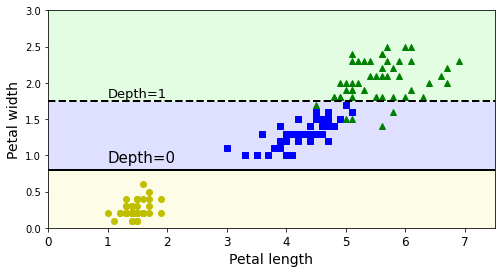

In [10]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)


plt.show()

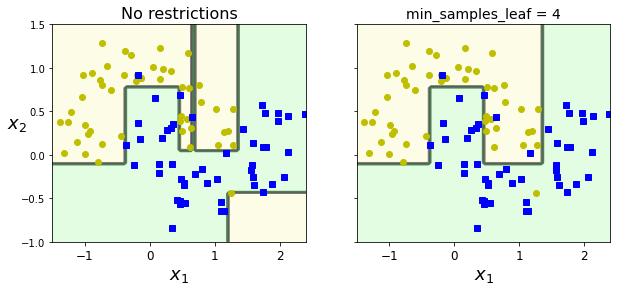

In [14]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")


plt.show()

- 사전 가지치기 : 트리생성을 일찍 중단
- 사후 가지치기 : 트리를 만든 후 데이터 포인트가 적은 노드를 삭제하거나 병합

#6.8 회귀

In [19]:
export_graphviz(
        tree_reg1,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

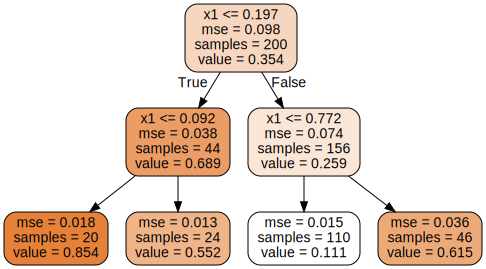

In [20]:
Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

#결정 트리 평가

###장점 

- 만들어진 모델을 쉽게 시각화할 수 있어서 비전문가도 이해하기 쉽다. 
- 데이터의 스케일에 구애받지 않는다는 것이다. 
> - 각 특성이 개별적으로 처리되어 데이터를 분할하기 때문에, 데이터 스케일의 영향을 받지 않으므로 결정 트리에서는 데이터가 특정 범위 안에 들어오도록 하는 정규화(Normalization)나 표준화(Standardization)같은 데이터 전처리 과정이 필요가 없다. 
> - 특히나 특성의 스케일이 서로 다르거나 이진 특성과 연속적인 특성이 혼합되어 있을 때에도 잘 작동한다. 

- 학습이 끝난 결정 트리의 작업 속도가 매우 빠르다는 것 또한 장점이다. 
- 결정 트리는 모델이 어떻게 훈련되었는지 경로의 해석이 가능하다는 것이다.



###단점
- 결정 트리의 단점은 사전 가지치기를 사용함에도 과대적합(Overfitting)되는 경향이 있어 모델의 일반화 성능이 좋지 않다는 것이다.
- 단일 결정 트리의 이러한 단점을 보완한 것이 결정 트리의 앙상블 방법이다.
